*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module02_03_perceptron.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Linear models for classification: the perceptron


## Labeled data

Reminder:  A labeled dataset is a collection of feature vectors and their associated labels:

$$
\mathcal{D} = \{ \;(\mathbf{x}_i, y_i) \; \}_{i=1}^N
$$

where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i$ is the label associated with $\mathbf{x}_i$.
$\mathbb{R}^d$ is the set of all $d$-dimensional vectors with entries that are real numbers.

In this notebook we will focus on binary classification problems where the each example is classified into one of two classes, typically $\{ -1, 1 \}$, or $\{0, 1\}$.


In [2]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.6, random_state=1)
X.shape, y.shape

((100, 2), (100,))

This data is **linearly separable**:  there exists a hyperplane defined by $(\mathbf{w}, b)$ that correctly classifies the data.

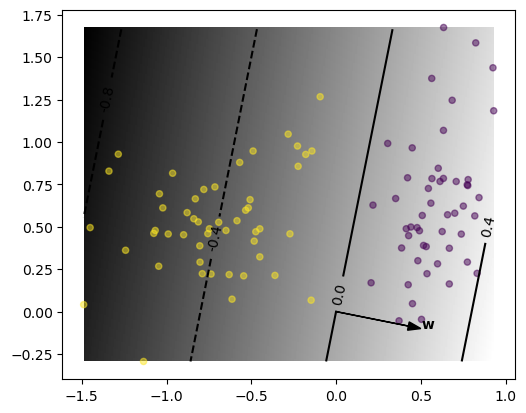

In [3]:
plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=y, alpha=0.5, s=20, cmap='viridis');

w = np.array([0.5, -0.1])
b = 0
delta = 0.01
xmin=np.min(X[:,0]);xmax=np.max(X[:,0]);ymin=np.min(X[:,1]);ymax=np.max(X[:,1])
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = w[0] * x_grid + w[1] * y_grid + b
    
im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 3, origin='lower',
                colors = 'black')

plt.clabel(C, fmt='%1.1f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1], r"$\mathbf{w}$");


While not all datasets are linearly separable, we will start by solving this simpler problem.
Also, we will focus on hyperplanes that go through the origin, i.e. $b=0$.

## The perceptron algorithm

The perceptron algorithm, proposed in 1958 by Frank Rosenblatt, is one of the first machine learning algorithms.  It is the precursor of neural networks.

**Idea:** iterate over the training examples, and update the weight vector $\mathbf{w}$ in a way that would make $\mathbf{x}_i$ is more likely to be correctly classified.

Let's assume $\mathbf{x}_i$ is a positive example that is incorrectly classified, i.e. $\mathbf{w}^\top \mathbf{x}_i < 0$.

Let's consider the update equation

$$
\mathbf{w}' = \mathbf{w} + \eta \mathbf{x}_i,
$$

where $1 > \eta > 0$ is a (small) positive number called the *learning rate*.

We'll verify that after the update we have that

$$
\mathbf{w}'^\top \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i.
$$

This has the desired effect making $\mathbf{x}_i$ be more likely to be classified.  This happens because the dot product of $\mathbf{x}_i$ with the weight vector is less likely to be negative after the update.

And indeed:

$$
\mathbf{w}'^\top \mathbf{x} = (\mathbf{w} + \eta \mathbf{x}_i)^\top  \mathbf{x}_i = \mathbf{w}^\top \mathbf{x}_i + \eta \mathbf{x}_i^\top  \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i
$$

The latter inequality holds since for any non-zero vector, $\mathbf{x}^\top \mathbf{x} > 0$.

### Exercise

In deriving this inequality we relied on the following properties of the dot product:

* For any non-zero vector $\mathbf{x}$, we have that $\mathbf{x}^\top \mathbf{x} > 0$.
* For any vectors $\mathbf{u}, \mathbf{v}, \mathbf{w}$, we have that $(\mathbf{u} + \mathbf{v})^\top \mathbf{w} = \mathbf{u}^\top \mathbf{w} + \mathbf{v}^\top \mathbf{w}$

Using the definition of the dot product, verify that these properties hold.

If $\mathbf{x}_i$ is a negative example, the update needs to be in the opposite direction.

Overall, we can summarize these two cases using the following equation:

$$
\mathbf{w}' = \mathbf{w} + y_i \eta \mathbf{x}_i
$$

This leads us to the following algorithm:

`The perceptron algorithm`

**input:**  a labeled dataset

**output:** a weight vector $\mathbf{w}$.

```
initialize w=0
converged = False
while not converged :
    converged = True
    for i in 1,...,N :
        if x_i is misclassified update w and set
            converged=False
return w
```

Next, let's create a Python class that implements this algorithm.

First, let's write a function that generates linearly separable data in two dimensions:

In [4]:
def generate_separable_data(N) :
    w = np.random.uniform(-1, 1, 2)
    X = np.random.uniform(-1, 1, [N, 2])
    y = np.sign(np.inner(w, X))
    return X,y,w

In [5]:
generate_separable_data(10)

(array([[-0.44396148, -0.32009585],
        [-0.37898321,  0.64238045],
        [-0.62509761,  0.15310178],
        [-0.42743879, -0.31905605],
        [-0.08643258,  0.3429693 ],
        [ 0.54188966,  0.52050297],
        [ 0.11496979,  0.3453577 ],
        [-0.85090775,  0.56905514],
        [ 0.24326358, -0.4714453 ],
        [ 0.66910663, -0.89839394]]),
 array([-1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.]),
 array([0.83858134, 0.90281445]))

The following is a function to display the data and the weight vector:

In [10]:
def plot_data(X, y, w) :
    fig = plt.figure(figsize=(4,4))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    a = -w[0]/w[1]
    pts = np.linspace(-1,1)
    plt.plot(pts, a*pts, 'k-')
    cols = {1: 'r', -1: 'b'}
    for i in range(len(X)): 
        plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6) 

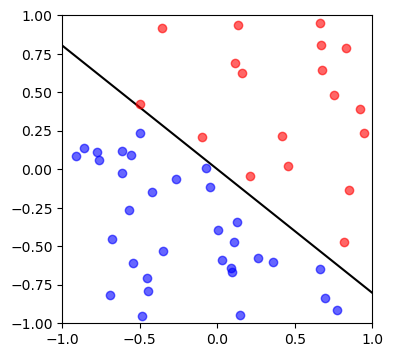

In [11]:
X,y,w = generate_separable_data(50)
plot_data(X, y, w)

And here's the Python class with the implementation of the perceptron:

In [12]:
class Perceptron :
 
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, max_iterations=100, learning_rate=0.2) :
 
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
 
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        self.w = np.zeros(len(X[0]))
        converged = False
        iterations = 0
        while (not converged and iterations <= self.max_iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    plot_data(X, y, self.w)
            iterations += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iterations)
        print ('weight vector: ' + str(self.w))
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
 
        scores = np.dot(X, self.w)
        return np.sign(scores)
 


converged in 2 iterations 
weight vector: [-0.16421483 -0.14072971]


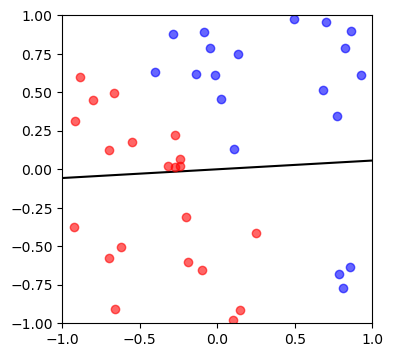

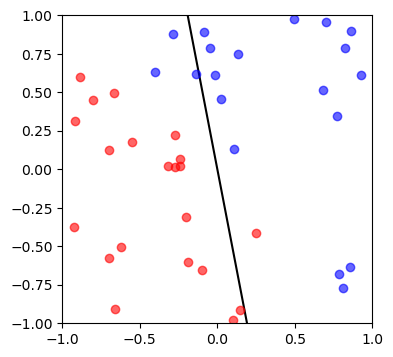

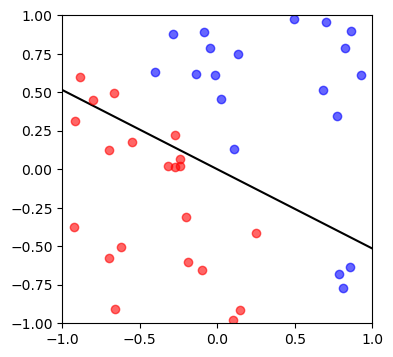

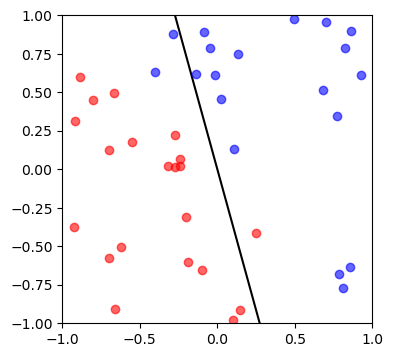

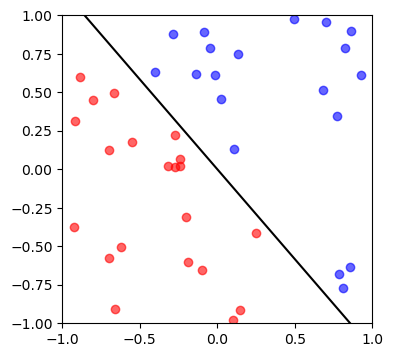

In [14]:
X,y,w = generate_separable_data(40)
p = Perceptron()
p.fit(X,y)

Let's compare the two weight vectors:

In [15]:
p.w, w

(array([-0.16421483, -0.14072971]), array([-0.65095772, -0.55312827]))

Let's normalize the two vectors into unit vectors:

In [17]:
print(p.w/np.sqrt(np.inner(p.w, p.w)))
print(w/np.sqrt(np.inner(w, w)))

[-0.75931569 -0.65072243]
[-0.76204663 -0.64752214]


Now we can see that they are pointing more or less in the same direction!

Our algorithm as stated above has several limitations:

* The hyperplane goes through the origin.
* The algorithm doesn't converge if the data is not linearly separable.

To address the second limitation, all you need to do is add a limit on the number of iterations, which is what we did in the code.
To address the first, we'll show a trick for introducing a bias without actually having to modify the algorithm.  To do so, we'll modify the data instead.

Let's add another dimension to our weight vector, and a constant feature to our data:

$\tilde{\mathbf{w}}=[w_1,\ldots,w_d,w_{d+1}]^\top$

$\tilde{\mathbf{x}}= [x_1,\ldots,x_d,1]^\top$

With these definitions, you can easily verify that 

$$
\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}} = \mathbf{w}^\top \mathbf{x}
+ w_{d+1}
$$

i.e. $w_{d+1}$ is equivalent to the bias term.

### Issues with the perceptron

Even with these fixes, there are still a couple of issues with the algorithm:

* Does not converge if the data is not separable (not so good solution: halt after a fixed number of iterations).

* The algorithm chooses an arbitrary hyperplane that separates the two classes.  It may not be the best one from the learning perspective.

During the rest of this course we will learn algorithms that  address these issues in different ways.

### Linear classifiers

The perceptron is a simple algorithm for constructing linear decision boundaries.  Now why would we want a linear classifier?

* It’s a good baseline:  always start simple
* Linear models are stable
* Linear models are *less likely to overfit* the training data because they have less parameters.  
* Can sometimes *underfit*.  
* Often all you need when the data is high dimensional.
* Lots of scalable algorithms.


### The perceptron and the origins of artificial neural networks

Frank Rosenblatt who invented the algorithm did not initially intend for its use as a machine learning algorithm (a term that did not exist at the time):

> The perceptron program is not primarily concerned with the invention of devices for "artificial intelligence", but rather with investigating the physical structures and neurodynamic principles which underlie "natural intelligence." A perceptron is first and foremost a brain model, not an invention for pattern recognition.

The limitations of the simple version of the perceptron shown here were described in great detail in the book [Perceptrons: an introduction to computational geometry](https://en.wikipedia.org/wiki/Perceptrons_(book)) by Minsky and Pappert.  Publication of this book has stalled the development of the field for close to a decade.

### References

* Rosenblatt, Frank. "The perceptron: a probabilistic model for information storage and organization in the brain." Psychological review 65.6 (1958): 386.